# EC1B1 Coursework
# Group 3
---
## 4. Data Cleaning

In [79]:
# Downloading the data

import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Google Sheets details
SHEET_ID = "1VnzB2MO5jEBzXqtkA0i_oNtONzOIg9y3I5nU1fB6DwU"
# List of sheets and their GIDs 
SHEET_GIDS = {
    "Sheet1": "0",  
    "Sheet2": "1811506178",
    "Sheet3": "1443003215",
    "Sheet4" : "746766865",
    "Sheet5" : "791351243",
    "Sheet6" : "68385636"
    
}

dfs = {}

# Loop through each sheet and fetch data
for sheet_name, gid in SHEET_GIDS.items():
    url = f"https://docs.google.com/spreadsheets/d/{SHEET_ID}/export?format=csv&gid={gid}"
    response = requests.get(url)

    if response.status_code == 200: # test if data fetched properly
        df = pd.read_csv(StringIO(response.text))  # Convert CSV text to DataFrame
        dfs[sheet_name] = df
        print(f"Extracted: {sheet_name} ✅")
    else:
        print(f"Failed to extract {sheet_name}, Status Code: {response.status_code}")

germany_data=dfs["Sheet5"]
us_data=dfs["Sheet6"]
data=dfs['Sheet4']


Extracted: Sheet1 ✅
Extracted: Sheet2 ✅
Extracted: Sheet3 ✅
Extracted: Sheet4 ✅
Extracted: Sheet5 ✅
Extracted: Sheet6 ✅


In [80]:
# process the us data
us_data.drop(us_data.columns[0], axis=1)
df5=us_data
df5.loc[-1] = df5.columns  # Insert the column names as a row at index -1
df5.index = df5.index + 1  # Shift index to start from 1 to maintain the order
df5 = df5.sort_index()  # Sort the DataFrame by index
df5.columns = range(df5.shape[1])
newdf5 = df5.T

newdf5 = newdf5.drop([0,1])

newdf5.columns = newdf5.iloc[0]

newdf5.columns = [ 'Date', 'Reserves', 'CPI']
us_df = newdf5.reset_index(drop=True) #reset index and assign it to the dataframe

In [81]:
# processing germany data
germany_data.drop(germany_data.columns[0], axis=1)
df4=germany_data
df4.loc[-1] = df4.columns  # Insert the column names as a row at index -1
df4.index = df4.index + 1  # Shift index to start from 1 to maintain the order
df4 = df4.sort_index()  # Sort the DataFrame by index
df4.columns = range(df4.shape[1])
newdf4 = df4.T

newdf4 = newdf4.drop([0,1])

newdf4.columns = newdf4.iloc[0]

newdf4.columns = [ 'Date', 'Industrial Production', 'Exchange Rate', 'Reserves', 'CPI']

germany_df = newdf4.reset_index(drop=True) #reset index of the df and assign it to a new name

germany_df = germany_df.applymap(lambda x: str(x).replace('Â', '') if isinstance(x, str) else x) # remove any characters which are not numeric or decimal from germany df
us_df = us_df.applymap(lambda x: str(x).replace('Â', '') if isinstance(x, str) else x) # remove any characters which are not numeric or decimal from us df

# processing germany data

def convert_to_int(value):
    if isinstance(value, str) and 'M' in value:
        value = value.replace(',', '')  # Remove commas
        return int(float(value.replace('M', '').strip()) * 1_000_000)
    return value  # Return as is if not in expected format

# Apply the function
germany_df['Reserves'] = germany_df['Reserves'].apply(convert_to_int)

us_df['Reserves'] = us_df['Reserves'].apply(convert_to_int)

/tmp/ipykernel_422/2971108123.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  germany_df = germany_df.applymap(lambda x: str(x).replace('Â', '') if isinstance(x, str) else x) # remove any characters which are not numeric or decimal from germany df
/tmp/ipykernel_422/2971108123.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  us_df = us_df.applymap(lambda x: str(x).replace('Â', '') if isinstance(x, str) else x) # remove any characters which are not numeric or decimal from us df


In [82]:
# save data to csv files 
germany_df.to_csv('germany_clean_data.csv', index=False) 
us_df.to_csv('us_clean_data.csv', index=False)

# Ensure a proper integer index
germany_df = germany_df.reset_index(drop=True)  

germany_df['Exchange Rate'] = germany_df['Exchange Rate'].str.replace(',', '').astype(float) # save exchange rate data as a float not a string


In [83]:
# CREATE EXCHANGE RATE GROWTH COLUMN

# Initialize a new column with null values
germany_df['Exchange Rate Growth'] = None

# Iteratively calculate and insert exchange rate growth
for i in range(1, len(germany_df)):  # Start from 1 because there's no previous value for the first row
    germany_df.loc[i, 'Exchange Rate Growth'] = ((germany_df.loc[i, 'Exchange Rate'] - germany_df.loc[i-1, 'Exchange Rate']) 
                                         / germany_df.loc[i-1, 'Exchange Rate']) * 100

# Display the updated DataFrame
germany_df

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth
0,Dec 1959,32.5,4.20,4811470000,24.62,None
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0
3,Mar 1960,32.2,4.20,4966460000,24.48,0.0
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0
...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293
369,Sep 1990,86.5,1.57,73197570000,67.77,0.0
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684


In [84]:
# CODE FOR REAL EXCHANGE RATE AND REAL EXCHANGE RATE GROWTH

# Ensure numeric conversion
germany_df['Exchange Rate'] = pd.to_numeric(germany_df['Exchange Rate'], errors='coerce')
germany_df['CPI'] = pd.to_numeric(germany_df['CPI'], errors='coerce')
us_df['CPI'] = pd.to_numeric(us_df['CPI'], errors='coerce')

# Align US CPI data to the same time period as germany_df 
germany_df['US CPI'] = us_df['CPI'].values  # Ensure correct alignment

# Calculate Real Exchange Rate (RER)
germany_df['Real Exchange Rate'] = germany_df['Exchange Rate'] * (germany_df['US CPI'] / germany_df['CPI'])

# Compute Monthly Growth in Real Exchange Rate
germany_df['Real Exchange Rate Growth'] = germany_df['Real Exchange Rate'].pct_change() * 100

# Display the updated DataFrame
germany_df

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth
0,Dec 1959,32.5,4.20,4811470000,24.62,None,13.48,2.299594,NaN
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217
3,Mar 1960,32.2,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833
...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121
369,Sep 1990,86.5,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590


In [85]:
# CODE FOR REAL EXCHANGE RATE INDEX

dec_1990_rer = germany_df.loc[germany_df['Date'] == 'Dec 1990', 'Real Exchange Rate'].values[0]

germany_df['Real Exchange Rate Index'] = germany_df['Real Exchange Rate'] / dec_1990_rer

# Display the updated DataFrame
germany_df

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index
0,Dec 1959,32.5,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951
3,Mar 1960,32.2,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504
...,...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121,1.046011
369,Sep 1990,86.5,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580,1.051582
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123,1.016763
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590,1.001028


In [86]:
# CODE FOR INFLATION

# Calculate monthly inflation rate
germany_df['Monthly Inflation Rate'] = germany_df['CPI'].pct_change() * 100

# Display the updated DataFrame
germany_df

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index,Monthly Inflation Rate
0,Dec 1959,32.5,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142,NaN
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053,0.000000
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951,-0.568643
3,Mar 1960,32.2,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951,0.000000
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504,0.571895
...,...,...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121,1.046011,0.311804
369,Sep 1990,86.5,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580,1.051582,0.310835
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123,1.016763,0.723034
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590,1.001028,-0.205098


In [87]:
#CODE FOR INDUSTRIAL PRODUCTION GROWTH

# Ensure Industrial Production values are numeric
germany_df['Industrial Production'] = pd.to_numeric(germany_df['Industrial Production'], errors='coerce')

# Calculate monthly growth rate in industrial production
germany_df['Monthly Industrial Production Growth'] = germany_df['Industrial Production'].pct_change() * 100

# Display the updated DataFrame
germany_df


,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index,Monthly Inflation Rate,Monthly Industrial Production Growth
0,Dec 1959,32.50,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142,NaN,NaN
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053,0.000000,-4.030769
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951,-0.568643,-0.480923
3,Mar 1960,32.20,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951,0.000000,3.737113
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504,0.571895,6.490683
...,...,...,...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121,1.046011,0.311804,-3.591826
369,Sep 1990,86.50,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580,1.051582,0.310835,13.875724
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123,1.016763,0.723034,7.098266
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590,1.001028,-0.205098,-3.432642


In [88]:
#The growth in industrial production versus 12 months ago 
new_germany_df = germany_df.copy() #creates a deep copy of the dataframe so changes don't affect the original frame

# Convert 'Date' to datetime format (using the 'Dec 1959' format)
new_germany_df['Date'] = pd.to_datetime(new_germany_df['Date'], format='%b %Y')

# Set the Date column as the index
new_germany_df.set_index('Date', inplace=True)

# Calculate the growth in industrial production versus 12 months ago
new_germany_df['Growth in Industrial Production'] = new_germany_df['Industrial Production'].pct_change(periods=12) * 100

# Display the updated DataFrame
new_germany_df

# add calculated values to main df
new_germany_df.reset_index(drop=True, inplace=True)
germany_df["Growth in Industrial Production"] = new_germany_df['Growth in Industrial Production']


germany_df

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index,Monthly Inflation Rate,Monthly Industrial Production Growth,Growth in Industrial Production
0,Dec 1959,32.50,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142,NaN,NaN,NaN
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053,0.000000,-4.030769,NaN
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951,-0.568643,-0.480923,NaN
3,Mar 1960,32.20,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951,0.000000,3.737113,NaN
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504,0.571895,6.490683,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121,1.046011,0.311804,-3.591826,6.015352
369,Sep 1990,86.50,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580,1.051582,0.310835,13.875724,5.513540
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123,1.016763,0.723034,7.098266,6.153317
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590,1.001028,-0.205098,-3.432642,5.582438


In [89]:
# RESERVES INDEX

# Extract the value in the 'Reserves' column for that row
dec_1959_row = germany_df[germany_df['Date'] == 'Dec 1959']
# Assuming 'Reserves' is the column name
base_value = dec_1959_row['Reserves'].iloc[0]
germany_df['Reserves Index'] = (germany_df['Reserves'] / base_value) * 100

germany_df


,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index,Monthly Inflation Rate,Monthly Industrial Production Growth,Growth in Industrial Production,Reserves Index
0,Dec 1959,32.50,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142,NaN,NaN,NaN,100.000000
1,Jan 1960,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053,0.000000,-4.030769,NaN,98.185378
2,Feb 1960,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951,-0.568643,-0.480923,NaN,99.893795
3,Mar 1960,32.20,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951,0.000000,3.737113,NaN,103.221261
4,Apr 1960,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504,0.571895,6.490683,NaN,108.825785
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,Aug 1990,75.96,1.57,72425740000,67.56,-4.268293,60.35,1.402450,-3.688121,1.046011,0.311804,-3.591826,6.015352,1505.272609
369,Sep 1990,86.50,1.57,73197570000,67.77,0.0,60.86,1.409919,0.532580,1.051582,0.310835,13.875724,5.513540,1521.314068
370,Oct 1990,92.64,1.52,75011930000,68.26,-3.184713,61.22,1.363235,-3.311123,1.016763,0.723034,7.098266,6.153317,1559.023126
371,Nov 1990,89.46,1.49,76166070000,68.12,-1.973684,61.36,1.342137,-1.547590,1.001028,-0.205098,-3.432642,5.582438,1583.010390


In [90]:
# US INFLATION

# Calculate monthly inflation rate
us_df['Monthly Inflation Rate'] = us_df['CPI'].pct_change() * 100

# Display the updated DataFrame
us_df

,Date,Reserves,CPI,Monthly Inflation Rate
0,Dec 1959,21504500000,13.48,NaN
1,Jan 1960,21478100000,13.44,-0.296736
2,Feb 1960,21395700000,13.48,0.297619
3,Mar 1960,21344700000,13.48,0.000000
4,Apr 1960,21278000000,13.53,0.370920
...,...,...,...,...
368,Aug 1990,78908840000,60.35,0.919732
369,Sep 1990,80024170000,60.86,0.845070
370,Oct 1990,82852200000,61.22,0.591522
371,Nov 1990,83059400000,61.36,0.228683


In [91]:
# US RESERVES INDEX

# Extract the value in the 'Reserves' column for that row
us_dec_1959_row = us_df[us_df['Date'] == 'Dec 1959']
# Assuming 'International Reserves' is the column name
base_value = us_dec_1959_row['Reserves'].iloc[0]
us_df['Reserves Index'] = (us_df['Reserves'] / base_value) * 100

us_df

,Date,Reserves,CPI,Monthly Inflation Rate,Reserves Index
0,Dec 1959,21504500000,13.48,NaN,100.000000
1,Jan 1960,21478100000,13.44,-0.296736,99.877235
2,Feb 1960,21395700000,13.48,0.297619,99.494059
3,Mar 1960,21344700000,13.48,0.000000,99.256900
4,Apr 1960,21278000000,13.53,0.370920,98.946732
...,...,...,...,...,...
368,Aug 1990,78908840000,60.35,0.919732,366.941059
369,Sep 1990,80024170000,60.86,0.845070,372.127555
370,Oct 1990,82852200000,61.22,0.591522,385.278430
371,Nov 1990,83059400000,61.36,0.228683,386.241949


In [92]:
# REFORMAT DATE TIME

germany_df['Date'] = pd.to_datetime(germany_df['Date'], format='%b %Y')
us_df['Date'] = pd.to_datetime(us_df['Date'], format='%b %Y')

In [93]:
# creating a combined df

germany_df_half = germany_df
germany_df_half["Country"] = "Germany"

us_df_half = us_df
us_df_half["Country"] = "USA"

combined_df = pd.concat([germany_df_half, us_df_half], axis=0, ignore_index=True)
pd.set_option('display.max_rows', None) 
display(combined_df)
pd.reset_option('display.max_rows')

,Date,Industrial Production,Exchange Rate,Reserves,CPI,Exchange Rate Growth,US CPI,Real Exchange Rate,Real Exchange Rate Growth,Real Exchange Rate Index,Monthly Inflation Rate,Monthly Industrial Production Growth,Growth in Industrial Production,Reserves Index,Country
0,1959-12-01,32.50,4.20,4811470000,24.62,None,13.48,2.299594,NaN,1.715142,NaN,NaN,NaN,100.000000,Germany
1,1960-01-01,31.19,4.20,4724160000,24.62,0.0,13.44,2.292770,-0.296736,1.710053,0.000000,-4.030769,NaN,98.185378,Germany
2,1960-02-01,31.04,4.20,4806360000,24.48,0.0,13.48,2.312745,0.871217,1.724951,-0.568643,-0.480923,NaN,99.893795,Germany
3,1960-03-01,32.20,4.20,4966460000,24.48,0.0,13.48,2.312745,0.000000,1.724951,0.000000,3.737113,NaN,103.221261,Germany
4,1960-04-01,34.29,4.20,5236120000,24.62,0.0,13.53,2.308123,-0.199833,1.721504,0.571895,6.490683,NaN,108.825785,Germany
5,1960-05-01,33.73,4.20,5417090000,24.69,0.0,13.53,2.301580,-0.283516,1.716624,0.284322,-1.633129,NaN,112.587006,Germany
6,1960-06-01,34.40,4.20,5843770000,24.69,0.0,13.57,2.308384,0.295639,1.721699,0.000000,1.986362,NaN,121.454982,Germany
7,1960-07-01,32.35,4.20,6124730000,24.69,0.0,13.57,2.308384,0.000000,1.721699,0.000000,-5.959302,NaN,127.294361,Germany
8,1960-08-01,31.15,4.20,6358680000,24.69,0.0,13.57,2.308384,0.000000,1.721699,0.000000,-3.709428,NaN,132.156701,Germany
9,1960-09-01,34.66,4.20,6643270000,24.62,0.0,13.57,2.314947,0.284322,1.726594,-0.283516,11.268058,NaN,138.071525,Germany


In [94]:
# save final dataframes as csv files
germany_df_half.to_csv('germany_data.csv', index=False)
us_df_half.to_csv('us_data.csv', index=False)
combined_df.to_csv('combined_data.csv', index=False)


## 5.2.1 Exchange Rates and International Reserve Graphs

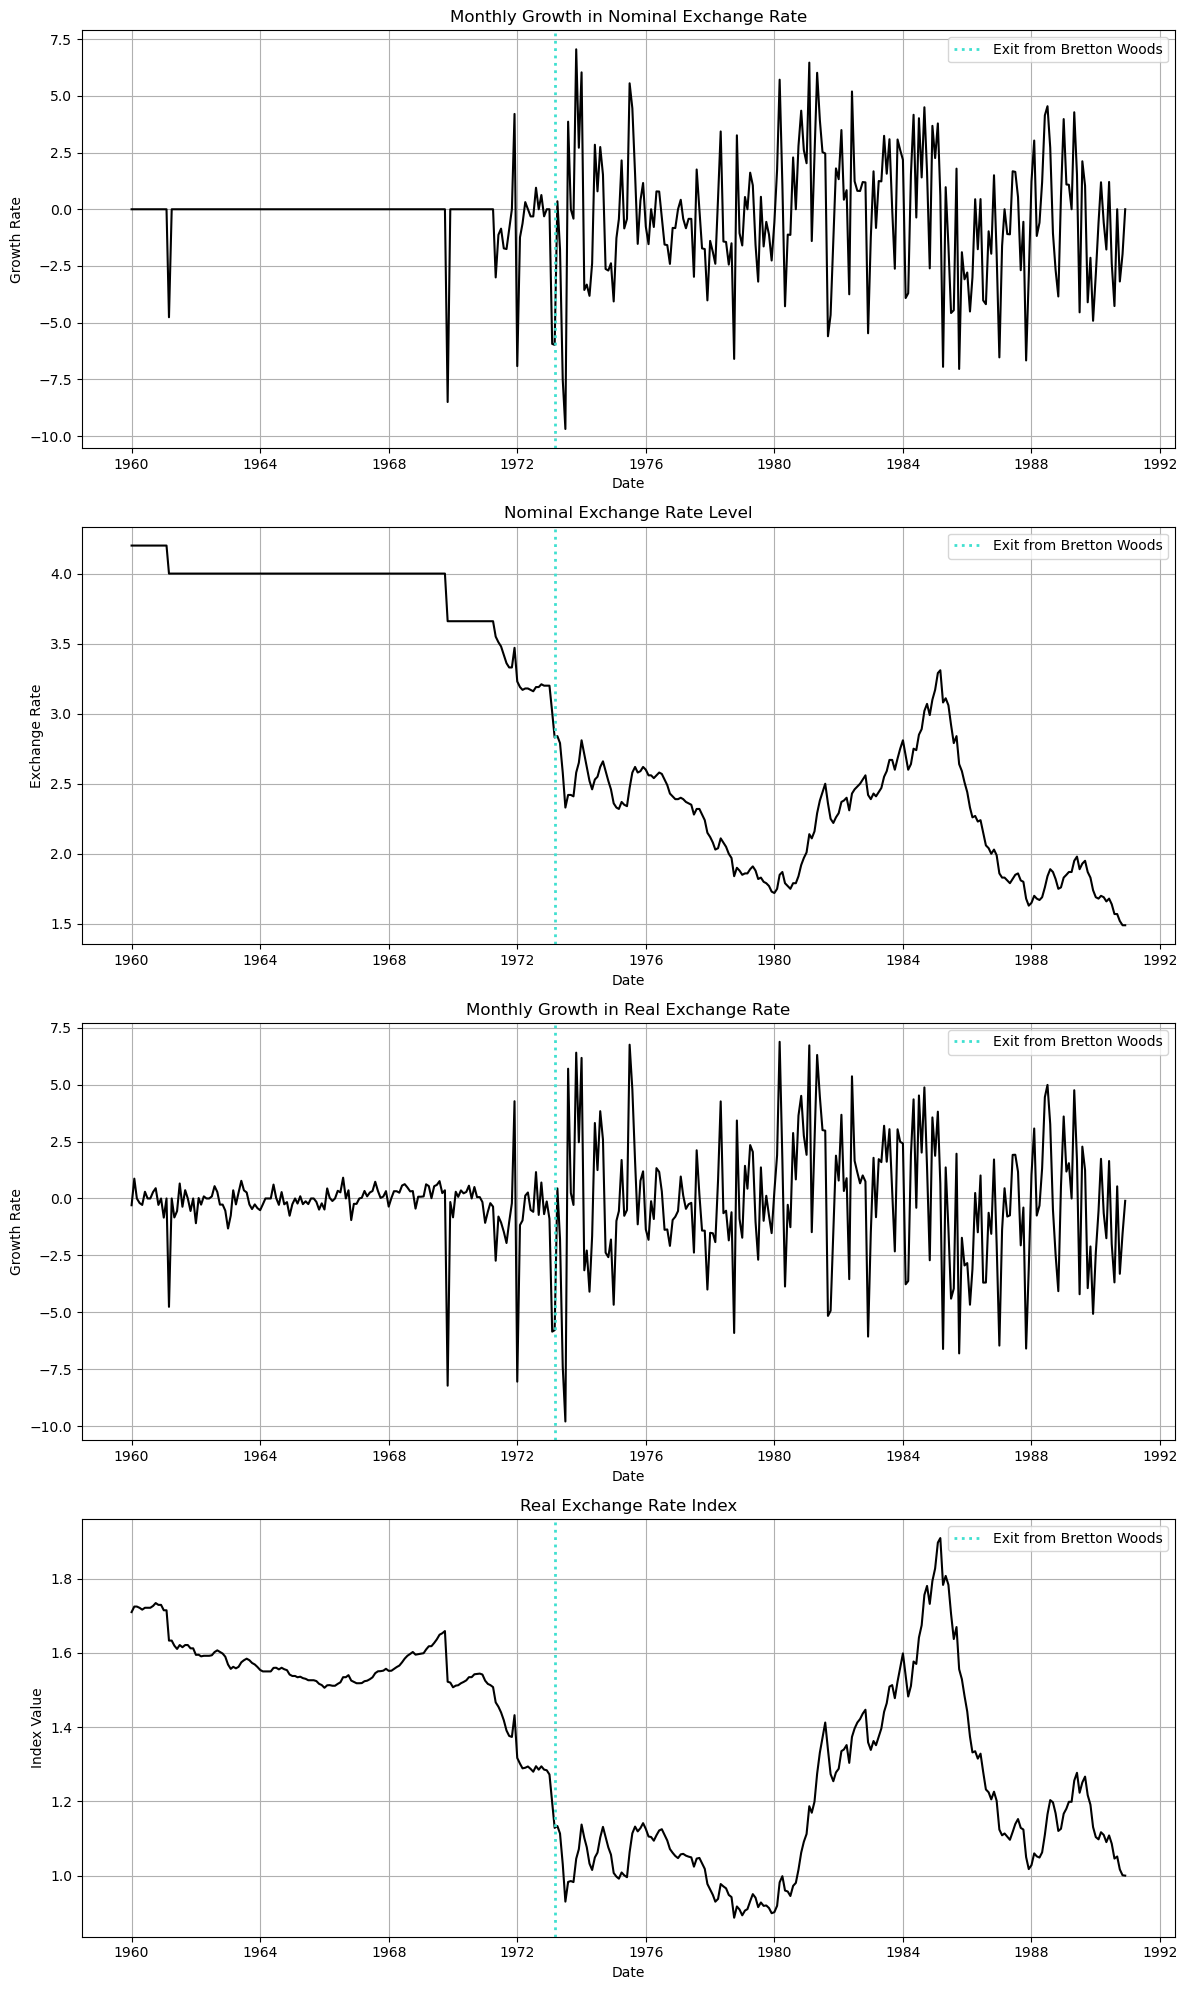

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("combined_data.csv")

# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define time range: January 1960 to December 1990
start_date = "1960-01-01"
end_date = "1990-12-31"
df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Define Germany Data 
germany = df['Country'].unique()[0] 
df_country = df[df['Country'] == germany].sort_values('Date')

# Set date Germany left the Bretton Woods system 
bretton_woods_exit = pd.to_datetime("1973-03-01")  

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=(12, 20))

# Line style for plots
line_style = '-'

# Bright contrasting color to clearly show Bretton Woods exit
bretton_line_color = 'turquoise'

# Monthly growth in the nominal exchange rate
axes[0].plot(df_country['Date'], df_country['Exchange Rate Growth'], linestyle=line_style, color='black')
axes[0].axvline(bretton_woods_exit, color=bretton_line_color, linestyle='dotted', linewidth=2, label="Exit from Bretton Woods")
axes[0].set_title("Monthly Growth in Nominal Exchange Rate")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Growth Rate")
axes[0].legend()
axes[0].grid()

# Level of the nominal exchange rate
axes[1].plot(df_country['Date'], df_country['Exchange Rate'], linestyle=line_style, color='black')
axes[1].axvline(bretton_woods_exit, color=bretton_line_color, linestyle='dotted', linewidth=2, label="Exit from Bretton Woods")
axes[1].set_title("Nominal Exchange Rate Level")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Exchange Rate")
axes[1].legend()
axes[1].grid()

# Monthly growth in the real exchange rate
axes[2].plot(df_country['Date'], df_country['Real Exchange Rate Growth'], linestyle=line_style, color='black')
axes[2].axvline(bretton_woods_exit, color=bretton_line_color, linestyle='dotted', linewidth=2, label="Exit from Bretton Woods")
axes[2].set_title("Monthly Growth in Real Exchange Rate")
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Growth Rate")
axes[2].legend()
axes[2].grid()

# Real exchange rate index
axes[3].plot(df_country['Date'], df_country['Real Exchange Rate Index'], linestyle=line_style, color='black')
axes[3].axvline(bretton_woods_exit, color=bretton_line_color, linestyle='dotted', linewidth=2, label="Exit from Bretton Woods")
axes[3].set_title("Real Exchange Rate Index")
axes[3].set_xlabel("Date")
axes[3].set_ylabel("Index Value")
axes[3].legend()
axes[3].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

# • Was the US dollar over or undervalued in the Bretton Woods system? Refer to data or figures in
# your answer.

# Under the Bretton-Woods system, the US dollar was overvalued. In the data and figures above, this is shown by: 
# The near permanent decline in Nominal Exchange Rate, with the price of one USD in deutschmarks post-Bretton Woods staying consistently lower than the Pegs under Bretton Woods (4.2/4/3.66) – the new nominal exchange rate only peaked at around 3.3, showing the pegs were grossly overvaluing the USD in deutschmark terms. 
# The Real Exchange Rate Index between German and US being >1.4 Pre-Nixon Shock to much closer to the range of 1 post-Bretton Woods until ~1980 also supports this, with the 40% higher than index real exchange rate showing that the USD was overvalued compared to the index 
# Monthly growth in both of these also shows large downward spikes and then a return to consistent volatility levels, showing that steady-state exchange rate level lay much lower than the one under Bretton-Woods

# • Using your above figures, explain one reason for the US’s departure from the Bretton Woods system.

# As stated previously, the huge overvaluation of the Pegs (4.2/4/3.66) compared to post-BW exchange rate (3.3), as well as the much higher than-index real-exchange rate (>40% higher pre-Nixon Shock) meant that the price of USD in Deutschmarks was unjustifiably high. 
# This led to an undesirable and unsustainable balance of payments deficit, as Germans were dissuaded from buying US exports due to how expensive they were in deutschmarks, and Americans were much more likely to buy imports rather than US domestic goods due to the relative cheapness in dollar terms. This balance of payments deficit was a contributing factor to exiting Bretton-Woods, as a floating rate would result in a re-rating of the exchange rate more in line with the true, lower value of the dollar in deutschmark terms. 



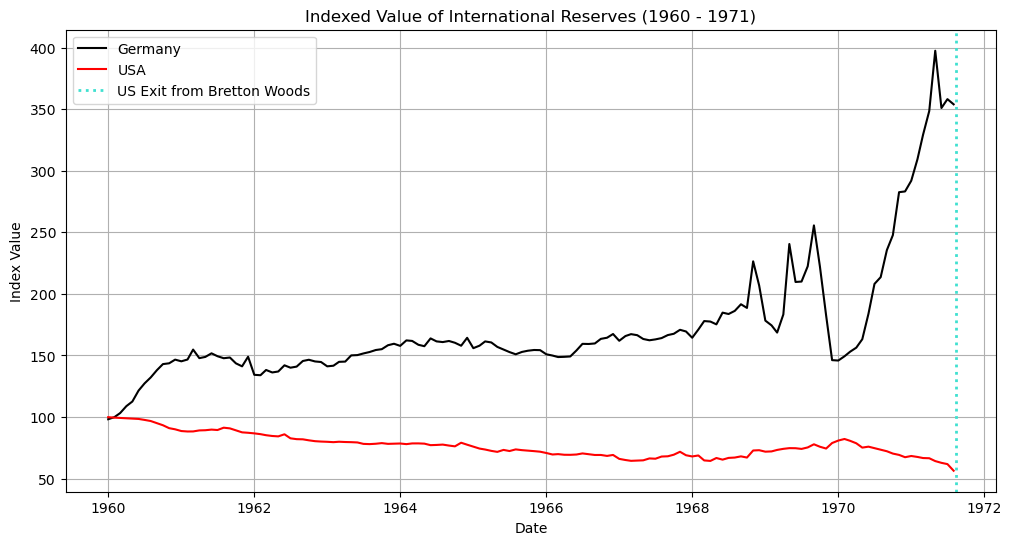

In [96]:

# Load the dataset 
df = pd.read_csv("combined_data.csv")

# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define time range: January 1960 until the US exit from Bretton Woods
start_date = "1960-01-01"
us_exit_bretton_woods = pd.to_datetime("1971-08-15")  # Adjust as needed

# Filter reserves data within the time range
df_reserves_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= us_exit_bretton_woods)]

# Get Germany Data
germany = df['Country'].unique()[0]  # Adjust if needed

# Extract reserves data for Germany and US
df_country_reserves = df_reserves_filtered[df_reserves_filtered['Country'] == germany][['Date', 'Reserves Index']]
df_us_reserves = df_reserves_filtered[df_reserves_filtered['Country'] == 'USA'][['Date', 'Reserves Index']]

# Create figure and axis
plt.figure(figsize=(12, 6))

# Plot reserves for Germany
plt.plot(df_country_reserves['Date'], df_country_reserves['Reserves Index'], linestyle='-', color='black', label=germany)

# Plot reserves for US
plt.plot(df_us_reserves['Date'], df_us_reserves['Reserves Index'], linestyle='-', color='red', label='USA')

# Mark US exit from Bretton Woods
plt.axvline(us_exit_bretton_woods, color='turquoise', linestyle='dotted', linewidth=2, label="US Exit from Bretton Woods")

# Labels and title
plt.title("Indexed Value of International Reserves (1960 - 1971)")
plt.xlabel("Date")
plt.ylabel("Index Value")
plt.legend()
plt.grid()

# Show plot
plt.show()


### 5.2.2 Inflation and Industrial Production Graphs
  
NOTE: Germany left the Bretton Woods System in March 1973. This will be indicated by a red dotted line at this date. 

Part 1: Data Import and Preprocessing
If you haven’t already loaded and preprocessed the data, run this first. This step ensures we have the correct timeframe (January 1960 to December 1990) and the dataset is properly formatted.

In [97]:
# Load the data
df = pd.read_csv('combined_data.csv')

# Convert Date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Filter the required period
start_date = pd.to_datetime('1960-01-01')
end_date = pd.to_datetime('1990-12-31')
df_full = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Display the first few rows for confirmation
print(df_full.head())

        Date  Industrial Production  Exchange Rate    Reserves    CPI  \
1 1960-01-01                  31.19            4.2  4724160000  24.62   
2 1960-02-01                  31.04            4.2  4806360000  24.48   
3 1960-03-01                  32.20            4.2  4966460000  24.48   
4 1960-04-01                  34.29            4.2  5236120000  24.62   
5 1960-05-01                  33.73            4.2  5417090000  24.69   

   Exchange Rate Growth  US CPI  Real Exchange Rate  \
1                   0.0   13.44            2.292770   
2                   0.0   13.48            2.312745   
3                   0.0   13.48            2.312745   
4                   0.0   13.53            2.308123   
5                   0.0   13.53            2.301580   

   Real Exchange Rate Growth  Real Exchange Rate Index  \
1                  -0.296736                  1.710053   
2                   0.871217                  1.724951   
3                   0.000000                  1.724951  

Part 2: Plotting Inflation Graphs
This section plots:

Monthly inflation in Germany
The difference between monthly inflation in Germany vs. the US

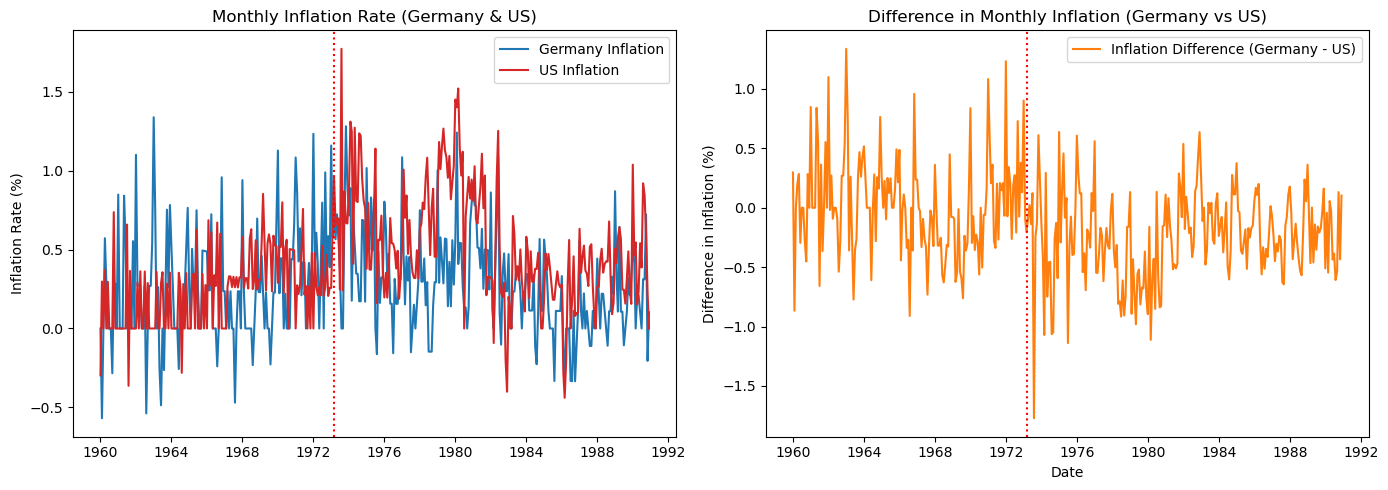

In [98]:
# Load the dataset
file_path = "combined_data.csv"  # Update this if needed
df = pd.read_csv(file_path, parse_dates=["Date"])

# Filter for Germany only
df_germany = df[df["Country"] == "Germany"].copy()

# Ensure numeric types for calculations
df_germany["Monthly Inflation Rate"] = pd.to_numeric(df_germany["Monthly Inflation Rate"], errors="coerce")
df_germany["US CPI"] = pd.to_numeric(df_germany["US CPI"], errors="coerce")

# Compute the monthly inflation rate for the US (assuming CPI changes reflect inflation)
df_germany["US Monthly Inflation Rate"] = df_germany["US CPI"].pct_change() * 100

# Compute the difference between Germany and US inflation rates
df_germany["Inflation Difference"] = df_germany["Monthly Inflation Rate"] - df_germany["US Monthly Inflation Rate"]

# Create the inflation plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot 1: Germany and US Monthly Inflation Rates
axs[0].plot(df_germany["Date"], df_germany["Monthly Inflation Rate"], label="Germany Inflation", color="tab:blue")
axs[0].plot(df_germany["Date"], df_germany["US Monthly Inflation Rate"], label="US Inflation", color="tab:red")
axs[0].axvline(pd.Timestamp("1973-03-01"), color="red", linestyle="dotted", linewidth=1.5)
axs[0].set_title("Monthly Inflation Rate (Germany & US)")
axs[0].set_ylabel("Inflation Rate (%)")
axs[0].legend()

# Plot 2: Difference between Germany and US Inflation Rates
axs[1].plot(df_germany["Date"], df_germany["Inflation Difference"], label="Inflation Difference (Germany - US)", color="tab:orange")
axs[1].axvline(pd.Timestamp("1973-03-01"), color="red", linestyle="dotted", linewidth=1.5)
axs[1].set_title("Difference in Monthly Inflation (Germany vs US)")
axs[1].set_ylabel("Difference in Inflation (%)")
axs[1].legend()

# Improve layout and show
plt.xlabel("Date")
plt.tight_layout()
plt.show()


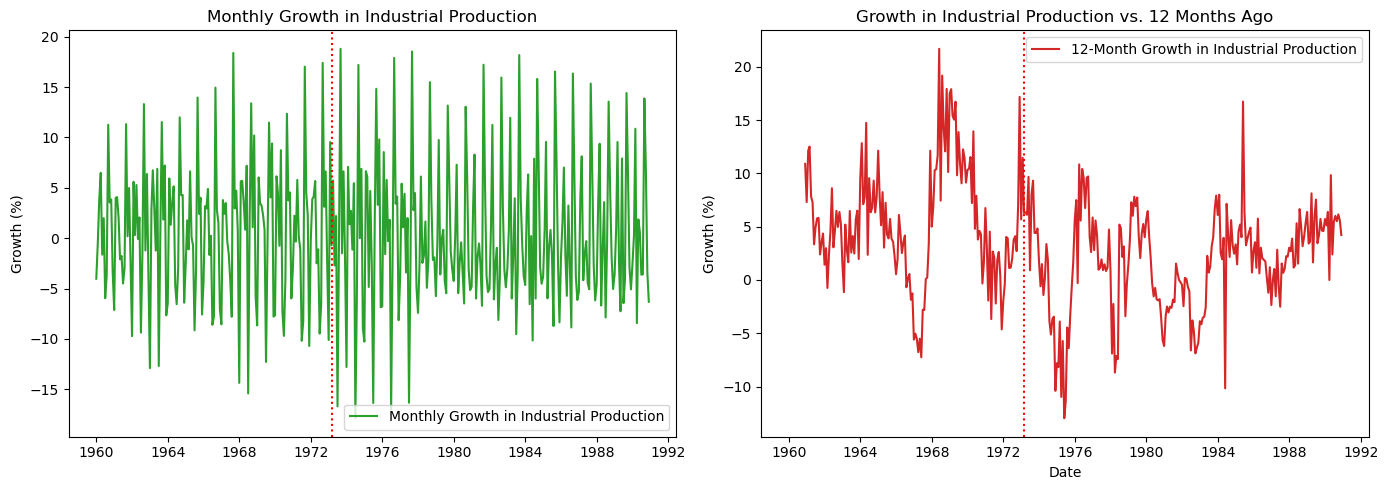

In [99]:
# Create a figure with 2 subplots (1 row x 2 columns)
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

# Plot 1: Monthly Growth in Industrial Production
axs[0].plot(df_full['Date'], df_full['Monthly Industrial Production Growth'], label='Monthly Growth in Industrial Production', color='tab:green')
axs[0].axvline(pd.Timestamp("1973-03-01"), color='red', linestyle='dotted', linewidth=1.5)
axs[0].set_title('Monthly Growth in Industrial Production')
axs[0].set_ylabel('Growth (%)')
axs[0].legend()

# Plot 2: Growth in Industrial Production vs. 12 Months Ago
axs[1].plot(df_full['Date'], df_full['Growth in Industrial Production'], label='12-Month Growth in Industrial Production', color='tab:red')
axs[1].axvline(pd.Timestamp("1973-03-01"), color='red', linestyle='dotted', linewidth=1.5)
axs[1].set_title('Growth in Industrial Production vs. 12 Months Ago')
axs[1].set_ylabel('Growth (%)')
axs[1].legend()

# Improve layout and show
plt.xlabel('Date')
plt.tight_layout()
plt.show()


### 5.2.3 Comparison Statistics & Visualisation

                                 Standard Deviation Before Bretton Woods  \
Exchange Rate Growth                                            0.867229   
Real Exchange Rate Growth                                       0.934809   
Monthly Inflation Rate                                          0.341028   
Inflation Difference                                            0.414240   
Growth in Industrial Production                                 5.614914   

                                 Standard Deviation After Bretton Woods  \
Exchange Rate Growth                                           2.884954   
Real Exchange Rate Growth                                      2.944687   
Monthly Inflation Rate                                         0.306578   
Inflation Difference                                           0.366527   
Growth in Industrial Production                                4.686166   

                                 Ratio (Before / After)  
Exchange Rate Growth              

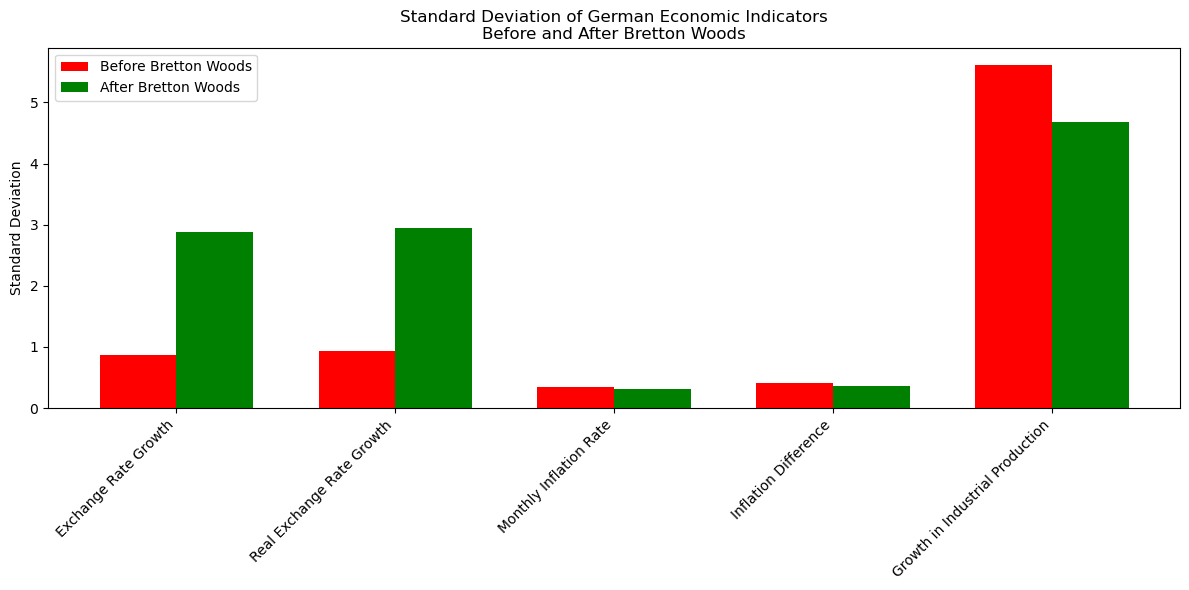

In [100]:

# Load the dataset
df = pd.read_csv("combined_data.csv")

# Convert Date officially to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Define Bretton Woods periods
before_bretton_woods_end = "1971-06-30"
after_bretton_woods_start = "1973-03-01"

# Separate data for Germany and USA
df_germany = df[df['Country'] == 'Germany']
df_us = df[df['Country'] == 'USA']

# Compute Inflation Difference by merging Germany and US data on Date (reconciling stacked table)
df_merged = pd.merge(df_germany[['Date', 'Monthly Inflation Rate']],
                      df_us[['Date', 'Monthly Inflation Rate']],
                      on='Date', suffixes=('_Germany', '_US'))
df_merged['Inflation Difference'] = df_merged['Monthly Inflation Rate_Germany'] - df_merged['Monthly Inflation Rate_US']

# Merge inflation difference back to Germany dataset
df_germany = df_germany.merge(df_merged[['Date', 'Inflation Difference']], on='Date', how='left')

# Filter data before and after Bretton Woods
df_before = df_germany[df_germany['Date'] <= before_bretton_woods_end]
df_after = df_germany[df_germany['Date'] >= after_bretton_woods_start]

# Variables to calculate standard deviation for
variables = [
    "Exchange Rate Growth",  # Monthly growth of nominal exchange rate
    "Real Exchange Rate Growth",  # Monthly growth of real exchange rate
    "Monthly Inflation Rate",  # Inflation rate in Germany
    "Inflation Difference",  # Difference between Germany's inflation and US inflation
    "Growth in Industrial Production"  # 12-monthly industrial production growth
]

# Doublecheck no issue with variables in dataset
variables = [var for var in variables if var in df_germany.columns]

# Compute standard deviations
std_before = df_before[variables].std()
std_after = df_after[variables].std()

# Compute ratio of standard deviations (before & after)
std_ratio = std_before / std_after

# Create results table
std_dev_table = pd.DataFrame({
    "Standard Deviation Before Bretton Woods": std_before,
    "Standard Deviation After Bretton Woods": std_after,
    "Ratio (Before / After)": std_ratio
})

# Save standard deviation table to CSV + Display
std_dev_table.to_csv("5.2.3_std_dev_table.csv", index=True)
print(std_dev_table)

# Get values from std_dev_table
labels = std_dev_table.index.tolist()
std_before_values = std_dev_table["Standard Deviation Before Bretton Woods"].values
std_after_values = std_dev_table["Standard Deviation After Bretton Woods"].values

# Set up the plot
x = range(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar([i - width/2 for i in x], std_before_values, width, label='Before Bretton Woods', color='red')
ax.bar([i + width/2 for i in x], std_after_values, width, label='After Bretton Woods', color='green')

# Labels and formatting
ax.set_ylabel('Standard Deviation')
ax.set_title('Standard Deviation of German Economic Indicators\nBefore and After Bretton Woods')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

# Why might it be a good idea to exclude data from 07/1971 - 02/1973 for the above calculations?

# Though the Nixon Shock was around 07/1991, until March of 1973, the official move of Germany to floating rates wasn’t finalised, with multiple failed attempts from both US/Europe to renew the Bretton Woods system. As this period represents a sort of transitory or extraneous period, without precise delineation of falling either pre or post-Bretton Woods, the data points within this time range should thus be excluded for the sake of clarity when calculating standard deviations. 






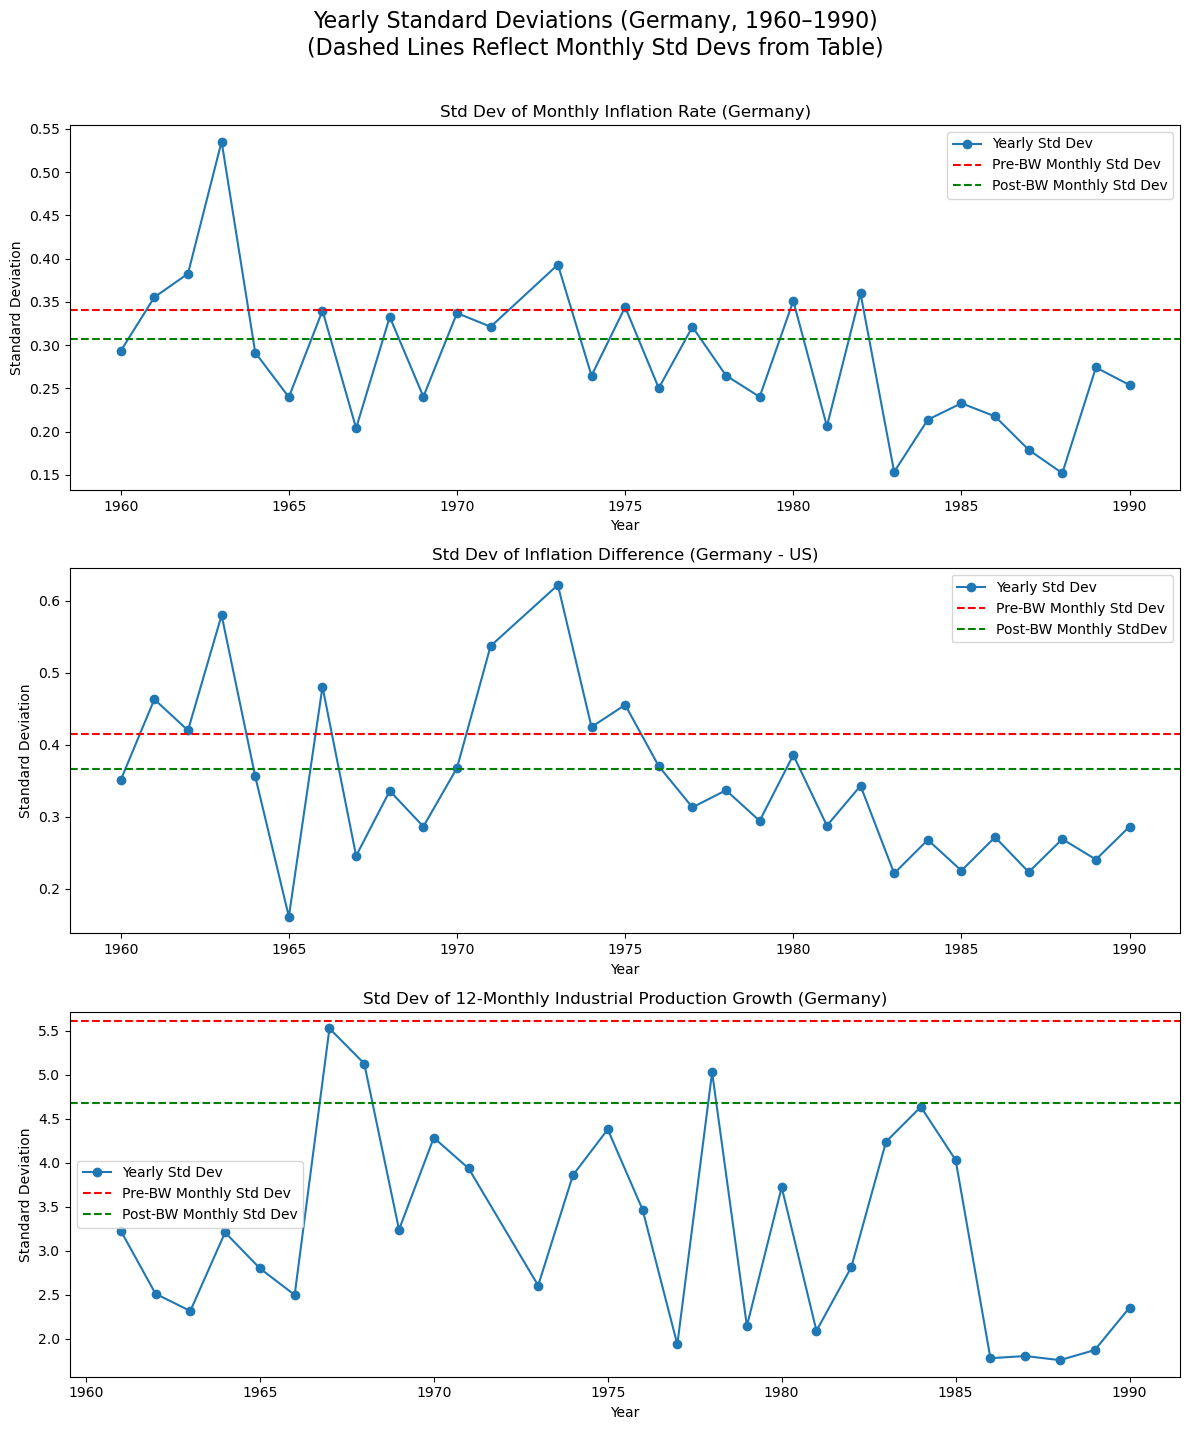

In [101]:
# Load & preprocess data for yearly instead of monthly
df = pd.read_csv("combined_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

# Filter Germany & US
df_germany = df[df['Country'] == 'Germany']
df_us = df[df['Country'] == 'USA']

# Compute Inflation Difference
df_merged = pd.merge(df_germany[['Date', 'Monthly Inflation Rate']],
                     df_us[['Date', 'Monthly Inflation Rate']],
                     on='Date', suffixes=('_Germany', '_US'))
df_merged['Inflation Difference'] = df_merged['Monthly Inflation Rate_Germany'] - df_merged['Monthly Inflation Rate_US']
df_germany = df_germany.merge(df_merged[['Date', 'Inflation Difference']], on='Date', how='left')

# Exclude transition period
df_germany = df_germany[(df_germany['Date'] < '1971-07-01') | (df_germany['Date'] > '1973-02-28')]
df_germany = df_germany[(df_germany['Year'] >= 1960) & (df_germany['Year'] <= 1990)]

# Compute yearly std devs
yearly_std_inflation = df_germany.groupby('Year')['Monthly Inflation Rate'].std().reset_index(name='Std_Inflation')
yearly_std_diff = df_germany.groupby('Year')['Inflation Difference'].std().reset_index(name='Std_Diff')
yearly_std_prod = df_germany.groupby('Year')['Growth in Industrial Production'].std().reset_index(name='Std_Prod')
yearly_std = yearly_std_inflation.merge(yearly_std_diff, on='Year').merge(yearly_std_prod, on='Year')

#Defining values from previous StDev Table
monthly_pre_bw_infl = std_before["Monthly Inflation Rate"]
monthly_post_bw_infl = std_after["Monthly Inflation Rate"]

monthly_pre_bw_diff = std_before["Inflation Difference"]
monthly_post_bw_diff = std_after["Inflation Difference"]

monthly_pre_bw_prod = std_before["Growth in Industrial Production"]
monthly_post_bw_prod = std_after["Growth in Industrial Production"]

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(12, 15))
fig.suptitle("Yearly Standard Deviations (Germany, 1960–1990)\n(Dashed Lines Reflect Monthly Std Devs from Table)", fontsize=16)

# 1. Monthly Inflation Rate
axs[0].plot(yearly_std['Year'], yearly_std['Std_Inflation'], marker='o', label='Yearly Std Dev')
axs[0].axhline(monthly_pre_bw_infl, color='red', linestyle='--', label='Pre-BW Monthly Std Dev')
axs[0].axhline(monthly_post_bw_infl, color='green', linestyle='--', label='Post-BW Monthly Std Dev')
axs[0].set_title("Std Dev of Monthly Inflation Rate (Germany)")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Standard Deviation")
axs[0].legend()

# 2. Inflation Difference
axs[1].plot(yearly_std['Year'], yearly_std['Std_Diff'], marker='o', label='Yearly Std Dev')
axs[1].axhline(monthly_pre_bw_diff, color='red', linestyle='--', label='Pre-BW Monthly Std Dev')
axs[1].axhline(monthly_post_bw_diff, color='green', linestyle='--', label='Post-BW Monthly StdDev')
axs[1].set_title("Std Dev of Inflation Difference (Germany - US)")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Standard Deviation")
axs[1].legend()

# 3. Industrial Production Growth
axs[2].plot(yearly_std['Year'], yearly_std['Std_Prod'], marker='o', label='Yearly Std Dev')
axs[2].axhline(monthly_pre_bw_prod, color='red', linestyle='--', label='Pre-BW Monthly Std Dev')
axs[2].axhline(monthly_post_bw_prod, color='green', linestyle='--', label='Post-BW Monthly Std Dev')
axs[2].set_title("Std Dev of 12-Monthly Industrial Production Growth (Germany)")
axs[2].set_xlabel("Year")
axs[2].set_ylabel("Standard Deviation")
axs[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


### 5.2.4 Regression Analysis

In [102]:

# Ensure Date column is in datetime format
df_germany["Date"] = pd.to_datetime(df_germany["Date"])

# Set Date as the index for resampling
df_germany.set_index("Date", inplace=True)

# Function to calculate 6-month standard deviation
def calculate_6_month_std(df, column):
    return df[column].resample("6M").std()

# Compute 6-month standard deviations
std_real_exch_growth = calculate_6_month_std(df_germany, "Real Exchange Rate Growth")
std_inflation_diff = calculate_6_month_std(df_germany, "Inflation Difference")
std_industrial_growth = calculate_6_month_std(df_germany, "Growth in Industrial Production")

# Merge results into a single DataFrame
std_data = pd.DataFrame({
    "Std_Real_Exchange_Growth": std_real_exch_growth,
    "Std_Inflation_Diff": std_inflation_diff,
    "Std_Industrial_Growth": std_industrial_growth
}).dropna()

# Reset index to keep Date as a column
std_data.reset_index(inplace=True)

# Display the results
print(std_data)

         Date  Std_Real_Exchange_Growth  Std_Inflation_Diff  \
0  1961-01-31                  0.457525            0.460190   
1  1961-07-31                  1.953781            0.521337   
2  1962-01-31                  0.510773            0.514927   
3  1962-07-31                  0.133704            0.134066   
4  1963-01-31                  0.654464            0.659728   
5  1963-07-31                  0.541119            0.542097   
6  1964-01-31                  0.285235            0.286204   
7  1964-07-31                  0.288470            0.288019   
8  1965-01-31                  0.331300            0.333099   
9  1965-07-31                  0.145078            0.145518   
10 1966-01-31                  0.221197            0.222280   
11 1966-07-31                  0.218734            0.219202   
12 1967-01-31                  0.627765            0.629974   
13 1967-07-31                  0.150776            0.150739   
14 1968-01-31                  0.366239            0.36

/tmp/ipykernel_422/2421429136.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return df[column].resample("6M").std()


Here is the manual calculation result for January to June 1964 for each of the three variables, (this equals row 6 above):

**Real Exchange Rate Growth:**

Values: [-0.5147, -0.2567, 0.0, 0.0, 0.0, 0.6111]
Mean = -0.0267

Standard Deviation = 0.3742

**Inflation Difference:***

Values: [0.5174, 0.2574, 0.0, 0.0, 0.0, -0.6096]
Mean = 0.0275

Standard Deviation = 0.3744

**Industrial Growth:**

Values: [9.5155, 12.8386, 7.1108, 7.7812, 14.7426, 2.3595]
Mean = 9.0580

Standard Deviation = 4.4070

In [103]:

# Prepare regression data
X = std_data["Std_Real_Exchange_Growth"]
X_poly = np.column_stack((X, X**2))  # Quadratic term
X = sm.add_constant(X)
X_poly = sm.add_constant(X_poly)

# Linear regressions
model_linear_inflation = sm.OLS(std_data["Std_Inflation_Diff"], X).fit()
model_linear_industrial = sm.OLS(std_data["Std_Industrial_Growth"], X).fit()

# Polynomial regressions
model_poly_inflation = sm.OLS(std_data["Std_Inflation_Diff"], X_poly).fit()
model_poly_industrial = sm.OLS(std_data["Std_Industrial_Growth"], X_poly).fit()

# Output regression summaries
print("Linear Regression - Inflation Difference:\n", model_linear_inflation.summary())
print("\nPolynomial Regression - Inflation Difference:\n", model_poly_inflation.summary())
print("\nLinear Regression - Industrial Growth:\n", model_linear_industrial.summary())
print("\nPolynomial Regression - Industrial Growth:\n", model_poly_industrial.summary())


Linear Regression - Inflation Difference:
                             OLS Regression Results                            
Dep. Variable:     Std_Inflation_Diff   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2453
Date:                Mon, 24 Mar 2025   Prob (F-statistic):              0.622
Time:                        13:45:55   Log-Likelihood:                 24.837
No. Observations:                  58   AIC:                            -45.67
Df Residuals:                      56   BIC:                            -41.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

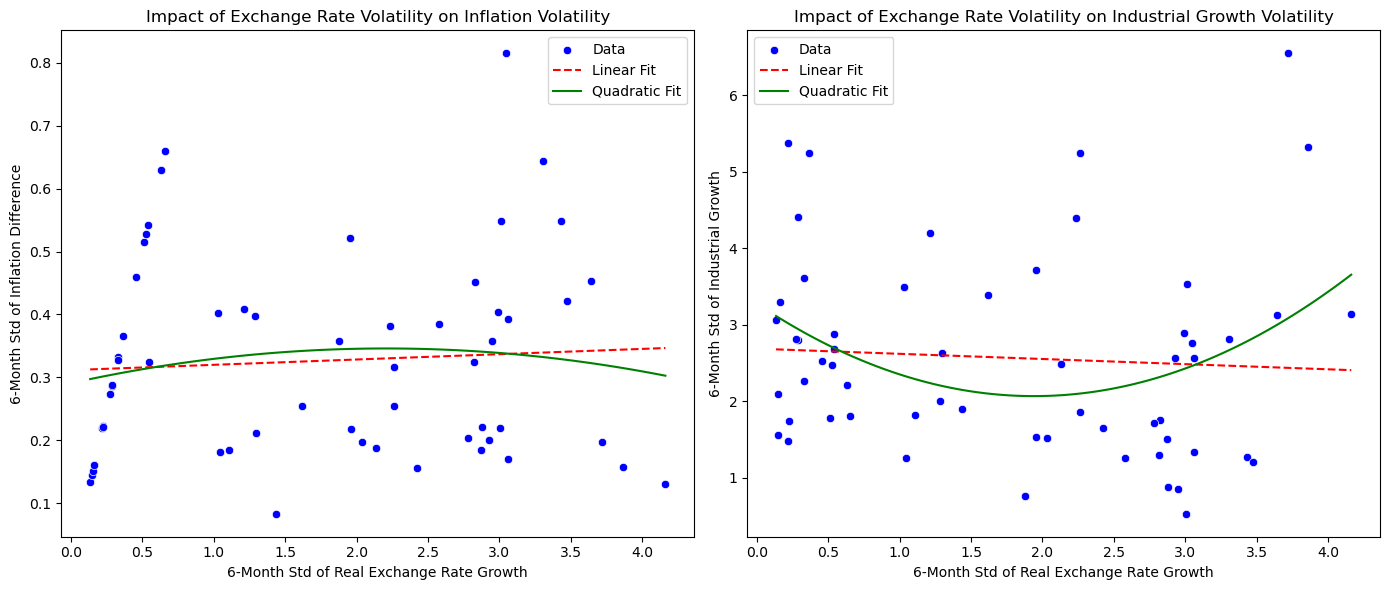

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Generate predictions for plotting
X_range = np.linspace(std_data["Std_Real_Exchange_Growth"].min(), std_data["Std_Real_Exchange_Growth"].max(), 100).reshape(-1, 1)
X_range_poly = np.column_stack((X_range, X_range**2))
X_range = sm.add_constant(X_range)
X_range_poly = sm.add_constant(X_range_poly)

# Predict values for both linear and quadratic regressions
inflation_pred_linear = model_linear_inflation.predict(X_range)
industrial_pred_linear = model_linear_industrial.predict(X_range)
inflation_pred_poly = model_poly_inflation.predict(X_range_poly)
industrial_pred_poly = model_poly_industrial.predict(X_range_poly)

# Create side-by-side scatter plots with best-fit lines
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Graph 1: Std of Inflation Difference vs. Std of Real Exchange Rate Growth
sns.scatterplot(x=std_data["Std_Real_Exchange_Growth"], y=std_data["Std_Inflation_Diff"], ax=axs[0], color="blue", label="Data")
axs[0].plot(X_range[:, 1], inflation_pred_linear, label="Linear Fit", color="red", linestyle="dashed")
axs[0].plot(X_range[:, 1], inflation_pred_poly, label="Quadratic Fit", color="green")
axs[0].set_title("Impact of Exchange Rate Volatility on Inflation Volatility")
axs[0].set_xlabel("6-Month Std of Real Exchange Rate Growth")
axs[0].set_ylabel("6-Month Std of Inflation Difference")
axs[0].legend()

# Graph 2: Std of Industrial Growth vs. Std of Real Exchange Rate Growth
sns.scatterplot(x=std_data["Std_Real_Exchange_Growth"], y=std_data["Std_Industrial_Growth"], ax=axs[1], color="blue", label="Data")
axs[1].plot(X_range[:, 1], industrial_pred_linear, label="Linear Fit", color="red", linestyle="dashed")
axs[1].plot(X_range[:, 1], industrial_pred_poly, label="Quadratic Fit", color="green")
axs[1].set_title("Impact of Exchange Rate Volatility on Industrial Growth Volatility")
axs[1].set_xlabel("6-Month Std of Real Exchange Rate Growth")
axs[1].set_ylabel("6-Month Std of Industrial Growth")
axs[1].legend()

plt.tight_layout()
plt.show()


### 6.2 Black Wednesday: The UK Joining & Leaving the ERM

Collecting additional data

In [105]:
#collecting exchange rate data
pd.options.mode.chained_assignment = None  #turn off warning messages as unnecessary in this context
#function to convert quarter formatting to graph readable dates
def convert_to_datetime(date):
    try:
        # If it's a full year (e.g., '1998'), convert to January 1st of that year
        if date.isdigit():
            return pd.to_datetime(date + '-01-01')
        # If it's in 'Qx YYYY' format (e.g., 'Q4 1998')
        elif 'Q' in date:
            return pd.to_datetime(date.replace('Q1', '01').replace('Q2', '04')
                                  .replace('Q3', '07').replace('Q4', '10'), format='%m %Y')
        else:
            return pd.NaT  # Return Not a Time for unrecognized formats
    except:
        return pd.NaT  # Catch errors

# Google Sheets link
sheet_url = "https://docs.google.com/spreadsheets/d/1lkPcze6wAjrg3Rzj_gd1wA_Y8HG2hMPC/edit?usp=drive_link&ouid=104629393755116582960&rtpof=true&sd=true"

# Convert the link to a CSV export link
csv_url = sheet_url.replace("/edit?usp=drive_link", "/gviz/tq?tqx=out:csv")

# Read the data into a DataFrame
df = pd.read_csv(csv_url)

# Set the first column as index (assuming it contains country names)
df.set_index(df.columns[0], inplace=True)

# Create a copy to avoid modifying a slice
df_cleaned = df.dropna(subset=['Germany', 'United Kingdom'], axis=1).copy()

# Add new row for DM/£ exchange rate
df_cleaned.loc['DM/£'] = df_cleaned.loc['Germany'] / df_cleaned.loc['United Kingdom']

# Reset the index so that 'Germany' and 'United Kingdom' become normal columns
df_cleaned = df.T.reset_index()

# Rename the index column to 'Date'
df_cleaned.rename(columns={'index': 'Date'}, inplace=True)

# Apply conversion to 'Date' column
df_cleaned['Date'] = df_cleaned['Date'].astype(str).apply(convert_to_datetime)

# Drop any remaining NaN values if needed
df_cleaned = df_cleaned.dropna(subset=['Date'])

# Sort by date (optional, but useful for plotting)
df_cleaned = df_cleaned.sort_values(by='Date')

# Reset index for better readability
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.rename(columns={'Germany':'Germany_ER','United Kingdom':'UK_ER'}, inplace=True)

display(df_cleaned)



International Financial Statistics (IFS),Date,Germany_ER,UK_ER
0,1950-01-01,4.19,0.36
1,1951-01-01,4.19,0.36
2,1952-01-01,4.19,0.36
3,1953-01-01,4.20,0.36
4,1954-01-01,4.20,0.36
...,...,...,...
342,2024-01-01,NaN,0.78
343,2024-01-01,NaN,0.79
344,2024-04-01,NaN,0.79
345,2024-07-01,NaN,0.77


In [106]:
#collecting CPI data
sheet_url = "https://docs.google.com/spreadsheets/d/1qbmUH8W7hympgmjrGSkiIiIXu0XurN-f/edit?usp=drive_link&ouid=104629393755116582960&rtpof=true&sd=true"

# Convert the link to a CSV export link
csv_url = sheet_url.replace("/edit?usp=drive_link", "/gviz/tq?tqx=out:csv")

# Read the data into a DataFrame
df2 = pd.read_csv(csv_url)

# Set the first column as index (assuming it contains country names)
df2.set_index(df2.columns[0], inplace=True)


# Create a copy to avoid modifying a slice
df_cleaned2 = df2.dropna(subset=['Germany', 'United Kingdom'], axis=1).copy()

# Reset index
df_cleaned2 = df2.T.reset_index()

# Rename the index column to 'Date'
df_cleaned2.rename(columns={'index': 'Date'}, inplace=True)

# Apply conversion to 'Date' column
df_cleaned2['Date'] = df_cleaned2['Date'].astype(str).apply(convert_to_datetime)

# Drop any remaining NaN values if needed
df_cleaned2 = df_cleaned2.dropna(subset=['Date'])

# Sort by date (optional, but useful for plotting)
df_cleaned2 = df_cleaned2.sort_values(by='Date')

# Reset index for better readability
df_cleaned2 = df_cleaned2.reset_index(drop=True)
df_cleaned2.rename(columns={'Germany':'Germany_CPI','United Kingdom':'UK_CPI'}, inplace=True)
# Display updated DataFrame
display(df_cleaned2)


International Financial Statistics (IFS),Date,Germany_CPI,UK_CPI
0,1951-01-01,7.65,NaN
1,1952-01-01,2.13,NaN
2,1953-01-01,-1.86,NaN
3,1954-01-01,0.24,NaN
4,1955-01-01,1.65,NaN
...,...,...,...
345,2024-01-01,2.26,3.27
346,2024-01-01,2.52,3.92
347,2024-04-01,2.29,2.87
348,2024-07-01,1.93,2.91


In [107]:
# collecting industrial production data 


sheet_url = "https://docs.google.com/spreadsheets/d/1vNlSvHgbiA_AWwftyPML7QPoVpUs3_3S/edit?usp=drive_link&ouid=104629393755116582960&rtpof=true&sd=true"

# Convert the link to a CSV export link
csv_url = sheet_url.replace("/edit?usp=drive_link", "/gviz/tq?tqx=out:csv")

# Read the data into a DataFrame
df3 = pd.read_csv(csv_url)

# Set the first column as index (assuming it contains country names)
df3.set_index(df3.columns[0], inplace=True)


# Create a copy to avoid modifying a slice
df_cleaned3 = df3.dropna(subset=['Germany', 'United Kingdom'], axis=1).copy()


df_cleaned3 = df3.T.reset_index()

# Rename the index column to 'Date'
df_cleaned3.rename(columns={'index': 'Date'}, inplace=True)

df_cleaned3 = df_cleaned3.dropna(subset=['Germany'])

df_cleaned3 = df_cleaned3.dropna(subset=['United Kingdom'])


# Apply conversion to 'Date' column
df_cleaned3['Date'] = df_cleaned3['Date'].astype(str).apply(convert_to_datetime)

# Drop any remaining NaN values if needed
df_cleaned3 = df_cleaned3.dropna(subset=['Date'])

# Reset index for better readability
df_cleaned3 = df_cleaned3.reset_index(drop=True)
df_cleaned3.rename(columns={'Germany':'Germany_IP','United Kingdom':'UK_IP'}, inplace=True)
# Display updated DataFrame
display(df_cleaned3)


International Financial Statistics (IFS),Date,Germany_IP,UK_IP
0,1958-01-01,27.33,44.74
1,1958-01-01,26.13,45.28
2,1958-04-01,27.50,42.98
3,1958-07-01,26.31,39.59
4,1958-10-01,28.70,45.01
...,...,...,...
323,2022-07-01,103.46,101.59
324,2022-10-01,105.88,105.04
325,2023-01-01,107.24,105.48
326,2023-04-01,102.09,103.39


In [108]:
#Merging to one dataframe
countries_df_temp = pd.merge(df_cleaned, df_cleaned2, on=['Date'], how='inner')
countries_df_temp2 = pd.merge(countries_df_temp, df_cleaned3, on=['Date'], how='inner')
#calculate dm/gdp exchange rate column
countries_df_temp2['DM/GBP'] = countries_df_temp2['Germany_ER']  / countries_df_temp2['UK_ER']  
countries_df = countries_df_temp2[
    (countries_df_temp2['Date'].dt.year >= 1980) & 
    (countries_df_temp2['Date'].dt.year <= 2000)
]
display(countries_df)

International Financial Statistics (IFS),Date,Germany_ER,UK_ER,Germany_CPI,UK_CPI,Germany_IP,UK_IP,DM/GBP
242,1980-01-01,1.82,0.43,5.44,17.97,66.64,70.31,4.232558
243,1980-01-01,1.82,0.43,5.44,17.97,67.79,74.62,4.232558
244,1980-01-01,1.82,0.43,5.52,19.08,66.64,70.31,4.232558
245,1980-01-01,1.82,0.43,5.52,19.08,67.79,74.62,4.232558
246,1980-01-01,1.77,0.44,5.44,17.97,66.64,70.31,4.022727
...,...,...,...,...,...,...,...,...
468,2000-01-01,NaN,0.62,1.55,1.11,89.91,102.30,NaN
469,2000-01-01,NaN,0.62,1.55,1.11,87.66,103.28,NaN
470,2000-04-01,NaN,0.65,1.11,1.05,88.67,100.24,NaN
471,2000-07-01,NaN,0.68,1.38,1.19,89.17,99.40,NaN


#### Question 1: What was a key reason for why the UK chose to join the ERM and fix their exchange rate? 
The UK joined the ERM to stabilize its currency, reduce inflation, and align with European economic policies.

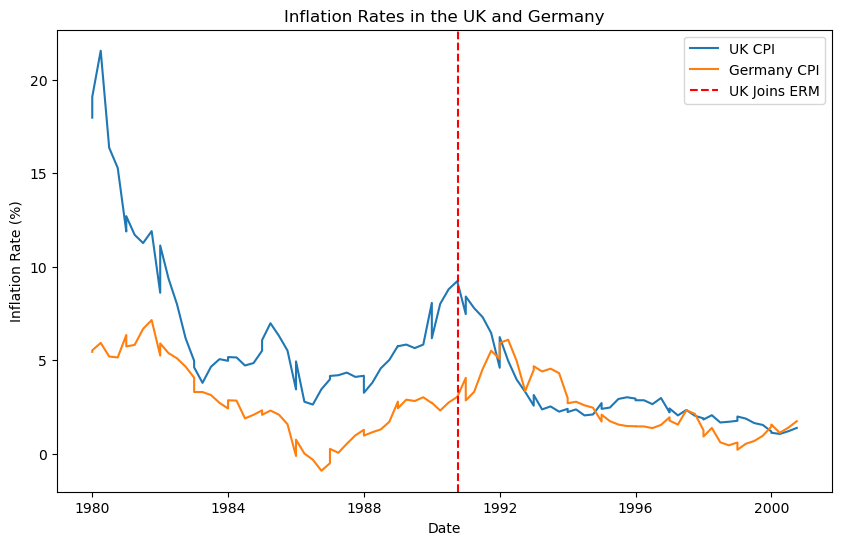

In [109]:

# Plot CPI
plt.figure(figsize=(10, 6)) #set figure size
plt.plot(countries_df['Date'], countries_df['UK_CPI'], label='UK CPI') #plot uk cpi data
plt.plot(countries_df['Date'], countries_df['Germany_CPI'], label='Germany CPI') #plot germany cpi data
plt.axvline(x=pd.to_datetime('1990-10-08'), color='r', linestyle='--', label='UK Joins ERM') #set date as x axis
plt.title('Inflation Rates in the UK and Germany')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.show()

#### Question 2: What factors led to George Soros and other currency speculators to run on the pound?

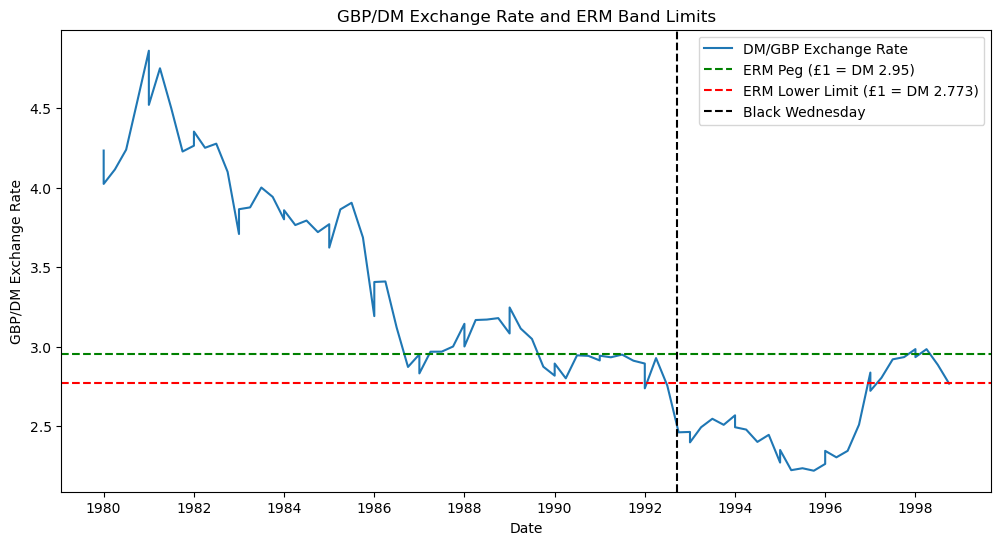

In [110]:
# Plot GBP/DM exchange rate and ERM band limits
plt.figure(figsize=(12, 6)) #set figure size 
plt.plot(countries_df['Date'], countries_df['DM/GBP'], label='DM/GBP Exchange Rate') #plot GBP/DM exchange rate 
plt.axhline(y=2.95, color='g', linestyle='--', label='ERM Peg (£1 = DM 2.95)') #add line for ERM Peg
plt.axhline(y=2.773, color='r', linestyle='--', label='ERM Lower Limit (£1 = DM 2.773)') #Add line for ERM lower limit
plt.axvline(x=pd.to_datetime('1992-09-16'), color='k', linestyle='--', label='Black Wednesday') #add line to indicate Black Wednesday
plt.title('GBP/DM Exchange Rate and ERM Band Limits')
plt.xlabel('Date')
plt.ylabel('GBP/DM Exchange Rate')
plt.legend()
plt.show()

#### Question 3: Is there evidence that the UK joining the ERM and leaving after Black Wednesday led to changes in the volatility of the monthly growth in the real exchange rate? Are there any corresponding changes in the volatility of either the difference in inflation between the UK and Germany or the growth in industrial production? 

In [111]:

# Calculate monthly growth rates
countries_df['Exchange Rate Growth'] = countries_df['DM/GBP'].pct_change() * 100  # Real exchange rate growth
countries_df['Inflation Difference'] = countries_df['UK_CPI'] - countries_df['Germany_CPI']  # Inflation difference
countries_df['Inflation Diff Growth'] = countries_df['Inflation Difference'].pct_change() * 100  # Inflation difference growth
countries_df['Industrial Production Growth'] = countries_df['UK_IP'].pct_change() * 100  # Industrial production growth



# Display the DataFrame
print("DataFrame with growth rates:")
display(countries_df)

DataFrame with growth rates:


/tmp/ipykernel_422/4084435776.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  countries_df['Exchange Rate Growth'] = countries_df['DM/GBP'].pct_change() * 100  # Real exchange rate growth


International Financial Statistics (IFS),Date,Germany_ER,UK_ER,Germany_CPI,UK_CPI,Germany_IP,UK_IP,DM/GBP,Exchange Rate Growth,Inflation Difference,Inflation Diff Growth,Industrial Production Growth
242,1980-01-01,1.82,0.43,5.44,17.97,66.64,70.31,4.232558,NaN,12.53,NaN,NaN
243,1980-01-01,1.82,0.43,5.44,17.97,67.79,74.62,4.232558,0.000000,12.53,0.000000,6.129996
244,1980-01-01,1.82,0.43,5.52,19.08,66.64,70.31,4.232558,0.000000,13.56,8.220271,-5.775931
245,1980-01-01,1.82,0.43,5.52,19.08,67.79,74.62,4.232558,0.000000,13.56,0.000000,6.129996
246,1980-01-01,1.77,0.44,5.44,17.97,66.64,70.31,4.022727,-4.957542,12.53,-7.595870,-5.775931
...,...,...,...,...,...,...,...,...,...,...,...,...
468,2000-01-01,NaN,0.62,1.55,1.11,89.91,102.30,NaN,0.000000,-0.44,69.230769,-0.948877
469,2000-01-01,NaN,0.62,1.55,1.11,87.66,103.28,NaN,0.000000,-0.44,0.000000,0.957967
470,2000-04-01,NaN,0.65,1.11,1.05,88.67,100.24,NaN,0.000000,-0.06,-86.363636,-2.943455
471,2000-07-01,NaN,0.68,1.38,1.19,89.17,99.40,NaN,0.000000,-0.19,216.666667,-0.837989


In [112]:
# Define the periods
pre_erm = countries_df[countries_df['Date'] < '1990-10-08']
during_erm = countries_df[(countries_df['Date'] >= '1990-10-08') & (countries_df['Date'] < '1992-09-16')]
post_black_wednesday = countries_df[countries_df['Date'] >= '1992-09-16']

# Calculate volatility (standard deviation of growth rates)
volatility = {
    'Pre-ERM': {
        'Exchange Rate': pre_erm['Exchange Rate Growth'].std(),
        'Inflation Difference': pre_erm['Inflation Diff Growth'].std(),
        'Industrial Production': pre_erm['Industrial Production Growth'].std()
    },
    'During ERM': {
        'Exchange Rate': during_erm['Exchange Rate Growth'].std(),
        'Inflation Difference': during_erm['Inflation Diff Growth'].std(),
        'Industrial Production': during_erm['Industrial Production Growth'].std()
    },
    'Post-Black Wednesday': {
        'Exchange Rate': post_black_wednesday['Exchange Rate Growth'].std(),
        'Inflation Difference': post_black_wednesday['Inflation Diff Growth'].std(),
        'Industrial Production': post_black_wednesday['Industrial Production Growth'].std()

    }
}

# Display volatility results
print("Volatility of Growth Rates:")
for period, metrics in volatility.items():
    print(f"\n{period}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

Volatility of Growth Rates:

Pre-ERM:
Exchange Rate: 3.1255
Inflation Difference: 29.5645
Industrial Production: 4.2999

During ERM:
Exchange Rate: 2.3991
Inflation Difference: 119.3985
Industrial Production: 3.1238

Post-Black Wednesday:
Exchange Rate: 2.5831
Inflation Difference: 521.4569
Industrial Production: 3.2214


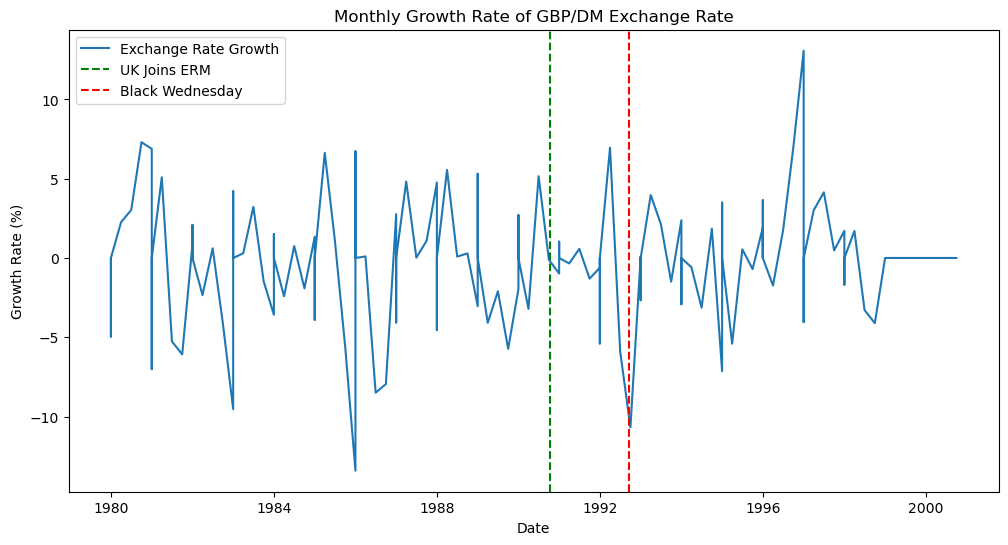

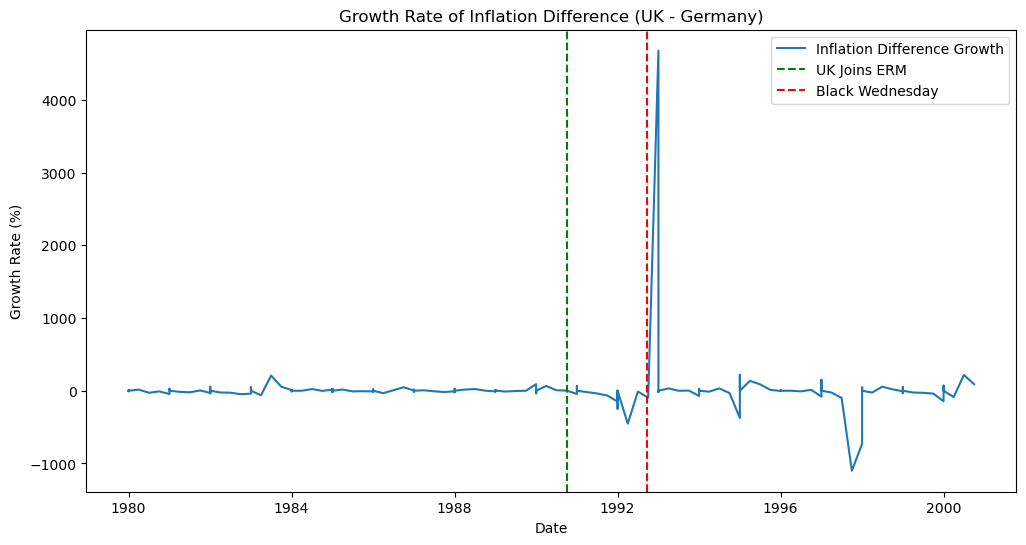

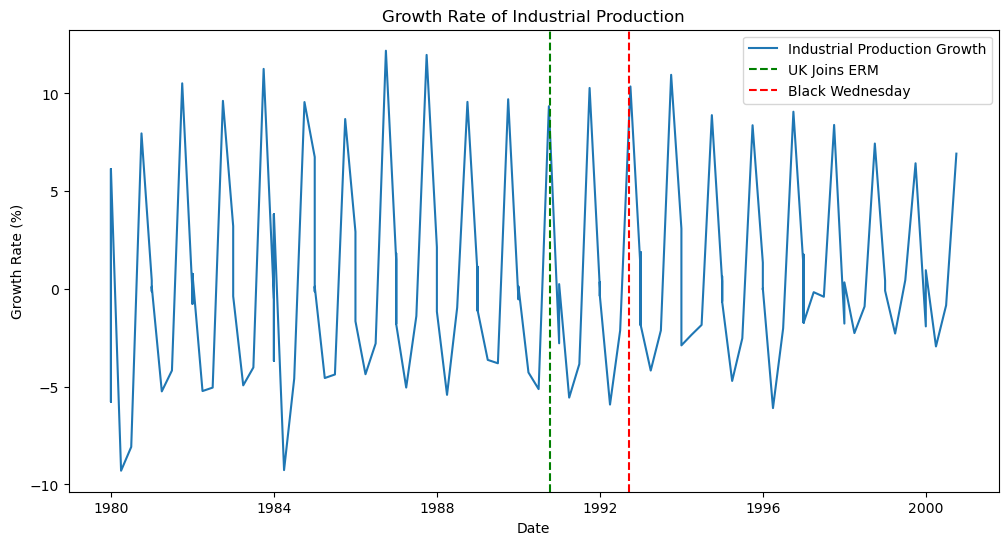

In [113]:
# Plot exchange rate growth volatility
plt.figure(figsize=(12, 6))
plt.plot(countries_df['Date'], countries_df['Exchange Rate Growth'], label='Exchange Rate Growth')
plt.axvline(x=pd.to_datetime('1990-10-08'), color='g', linestyle='--', label='UK Joins ERM')
plt.axvline(x=pd.to_datetime('1992-09-16'), color='r', linestyle='--', label='Black Wednesday')
plt.title('Monthly Growth Rate of GBP/DM Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()

# Plot inflation difference growth volatility
plt.figure(figsize=(12, 6))
plt.plot(countries_df['Date'], countries_df['Inflation Diff Growth'], label='Inflation Difference Growth')
plt.axvline(x=pd.to_datetime('1990-10-08'), color='g', linestyle='--', label='UK Joins ERM')
plt.axvline(x=pd.to_datetime('1992-09-16'), color='r', linestyle='--', label='Black Wednesday')
plt.title('Growth Rate of Inflation Difference (UK - Germany)')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()

# Plot industrial production growth volatility
plt.figure(figsize=(12, 6))
plt.plot(countries_df['Date'], countries_df['Industrial Production Growth'], label='Industrial Production Growth')
plt.axvline(x=pd.to_datetime('1990-10-08'), color='g', linestyle='--', label='UK Joins ERM')
plt.axvline(x=pd.to_datetime('1992-09-16'), color='r', linestyle='--', label='Black Wednesday')
plt.title('Growth Rate of Industrial Production')
plt.xlabel('Date')
plt.ylabel('Growth Rate (%)')
plt.legend()
plt.show()